# ShopTalk — ABO EDA & Embedding Model Comparison

**Goal**: Load the Amazon Berkeley Objects (ABO) dataset metadata, run quick EDA, generate embeddings with multiple pretrained models, and compare retrieval quality & clustering.

**Output**:
- Cleaned product text (title + description + optional captions)
- Embeddings from several encoders (e5 / bge / MiniLM; easily extendable)
- Retrieval metrics (Recall@K, nDCG@K) on a small eval set
- Inter-/intra-category cosine analysis
- UMAP projection plots

> ⚠️ This notebook downloads data from the web (ABO) and models from Hugging Face. Run in an environment with internet (Colab/Kaggle) and a GPU for speed.

## 0. Setup

Configure your environment and pick which encoders to benchmark.

In [ ]:
!pip -q install pandas numpy matplotlib umap-learn scikit-learn faiss-cpu sentence-transformers datasets rich

from pathlib import Path
import pandas as pd, numpy as np
from rich import print
from PIL import Image
from tqdm.auto import tqdm

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip.eval()

DATA_DIR = Path("./data_abo")
META_DIR = DATA_DIR / "meta"
IMG_DIR  = DATA_DIR / "images_main"   # local cache of main images
META_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# Choose encoders to compare
ENCODERS = {
    'e5-base': 'intfloat/e5-base-v2',
    'bge-base': 'BAAI/bge-base-en-v1.5',
    'MiniLM': 'sentence-transformers/all-MiniLM-L6-v2'
}
SEED = 42
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 69.7 MB/s eta 0:00:00


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

## 1. Download ABO metadata (sample) & optional images

ABO host: https://amazon-berkeley-objects.s3.amazonaws.com/index.html  
We'll pull a metadata CSV/JSONL sample (titles, categories, descriptions, URLs).

In [ ]:
import os
from pathlib import Path
import urllib.request

# DATA_DIR = Path("./data_abo")
# DATA_DIR.mkdir(parents=True, exist_ok=True)

url = "https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar"
tar_path = META_DIR / "abo-listings.tar"

if tar_path.exists() and tar_path.stat().st_size > 0:
    print("Using cached:", tar_path)
else:
    print("Downloading:", url)
    urllib.request.urlretrieve(url, str(tar_path))
    print("Saved to:", tar_path)
# A) Image metadata: maps image_id -> relative path
# If you don't have it yet, download:
# https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz
image_url = "https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz"
img_meta_path = IMG_DIR / "images.csv.gz"

if img_meta_path.exists() and img_meta_path.stat().size > 0:
  print("Using cached:", img_meta_path)
else:
  print("Downloading:", image_url)
  urllib.request.urlretrieve(image_url,img_meta_path)
  print("Saved images to path:", img_meta_path)

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Saved to: data_abo/meta/abo-listings.tar

Downloading: https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz

Saved images to path: data_abo/images_main/images.csv.gz

In [ ]:
import tarfile

with tarfile.open(tar_path, "r:*") as tar:
    members = tar.getmembers()
    print("Entries in tar:", len(members))
    # show the first 30 items so you get a sense of structure
    for m in members[:30]:
        kind = "DIR " if m.isdir() else "FILE"
        size_mb = f"{m.size/1e6:.2f} MB" if m.isfile() else ""
        print(f"{kind:4} {m.name} {size_mb}")

# Extract only *.json.gz files
extract_dir = META_DIR / "json_gz_files"
extract_dir.mkdir(parents=True, exist_ok=True)

with tarfile.open(tar_path, "r:*") as tar:
    for m in tar.getmembers():
        if m.isfile() and m.name.endswith(".json.gz"):
            print("Extracting:", m.name)
            tar.extract(m, path=extract_dir)

print("Done. Extracted to:", extract_dir)


Entries in tar: 20

FILE LICENSE-CC-BY-4.0.txt 0.01 MB

DIR  listings

FILE listings/README.md 0.01 MB

DIR  listings/metadata

FILE listings/metadata/listings_7.json.gz 5.43 MB

FILE listings/metadata/listings_4.json.gz 5.55 MB

FILE listings/metadata/listings_2.json.gz 5.45 MB

FILE listings/metadata/listings_c.json.gz 5.44 MB

FILE listings/metadata/listings_6.json.gz 5.50 MB

FILE listings/metadata/listings_0.json.gz 5.45 MB

FILE listings/metadata/listings_9.json.gz 5.50 MB

FILE listings/metadata/listings_e.json.gz 5.50 MB

FILE listings/metadata/listings_1.json.gz 5.35 MB

FILE listings/metadata/listings_5.json.gz 5.58 MB

FILE listings/metadata/listings_3.json.gz 5.39 MB

FILE listings/metadata/listings_d.json.gz 5.41 MB

FILE listings/metadata/listings_f.json.gz 5.46 MB

FILE listings/metadata/listings_8.json.gz 5.57 MB

FILE listings/metadata/listings_a.json.gz 5.46 MB

FILE listings/metadata/listings_b.json.gz 5.41 MB

Extracting: listings/metadata/listings_7.json.gz

/tmp/ipython-input-3552223255.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extract(m, path=extract_dir)


Extracting: listings/metadata/listings_4.json.gz

Extracting: listings/metadata/listings_2.json.gz

Extracting: listings/metadata/listings_c.json.gz

Extracting: listings/metadata/listings_6.json.gz

Extracting: listings/metadata/listings_0.json.gz

Extracting: listings/metadata/listings_9.json.gz

Extracting: listings/metadata/listings_e.json.gz

Extracting: listings/metadata/listings_1.json.gz

Extracting: listings/metadata/listings_5.json.gz

Extracting: listings/metadata/listings_3.json.gz

Extracting: listings/metadata/listings_d.json.gz

Extracting: listings/metadata/listings_f.json.gz

Extracting: listings/metadata/listings_8.json.gz

Extracting: listings/metadata/listings_a.json.gz

Extracting: listings/metadata/listings_b.json.gz

Done. Extracted to: data_abo/meta/json_gz_files

In [ ]:
import gzip
import json
import pandas as pd
from pathlib import Path

# Where you extracted the tar file
extract_dir = Path("data_abo/meta/json_gz_files")

# Find all .json.gz files
json_gz_files = list(extract_dir.rglob("*.json.gz"))
print("Found", len(json_gz_files), "json.gz files")

rows = []

# Read all files line by line
for file in json_gz_files:
    print("Reading:", file)
    with gzip.open(file, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                rows.append(json.loads(line))
            except Exception as e:
                print(f"Skipping bad line in {file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)
print("Combined shape:", df.shape)
print(df.head(5))
df.columns


Found 16 json.gz files

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_7.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_4.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_6.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_1.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_d.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_2.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_e.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_f.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_0.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_b.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_a.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_3.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_c.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_9.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_5.json.gz

Reading: data_abo/meta/json_gz_files/listings/metadata/listings_8.json.gz

Combined shape:
(147702, 28)

brand  \
0  [{'language_tag': 'fr_FR', 'value': 'Amazon Es...   
1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
2  [{'language_tag': 'en_SG', 'value': 'AmazonBas...   
3  [{'language_tag': 'it_IT', 'value': 'AmazonBas...   
4  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

                                        bullet_point  \
0  [{'language_tag': 'fr_FR', 'value': 'Plat clas...   
1  [{'language_tag': 'en_IN', 'value': 'Snug fit ...   
2  [{'language_tag': 'en_SG', 'value': 'For best ...   
3                                                NaN   
4  [{'language_tag': 'en_IN', 'value': '3D Printe...   

                                               color  \
0  [{'language_tag': 'fr_FR', 'standardized_value...   
1  [{'language_tag': 'en_IN', 'standardized_value...   
2                                                NaN   
3                                                NaN   
4  [{'language_tag': 'en_IN', 'standardized_value...   

                                         fabric_type     item_id  \
0  [{'language_tag': 'fr_FR', 'value': '100% Synt...  B07NQ437BB   
1                                                NaN  B0857LSVB7   
2                                                NaN  B07C5FF8QS   
3                                                NaN  B07K591232   
4                                                NaN  B07TG425LX   

                                           item_name  \
0  [{'language_tag': 'fr_FR', 'value': 'Amazon Es...   
1  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   
2  [{'language_tag': 'en_SG', 'value': 'AmazonBas...   
3  [{'language_tag': 'it_IT', 'value': 'AmazonBas...   
4  [{'language_tag': 'en_IN', 'value': 'Amazon Br...   

                                         item_weight  \
0  [{'normalized_value': {'unit': 'pounds', 'valu...   
1  [{'normalized_value': {'unit': 'pounds', 'valu...   
2                                                NaN   
3                                                NaN   
4  [{'normalized_value': {'unit': 'pounds', 'valu...   

                                          model_name  \
0      [{'language_tag': 'fr_FR', 'value': 'Manny'}]   
1  [{'language_tag': 'en_IN', 'value': 'Samsung G...   
2                                                NaN   
3                                                NaN   
4  [{'language_tag': 'en_IN', 'value': 'Huawei P9...   

                     model_number                        product_type  ...  \
0            [{'value': 'Manny'}]                [{'value': 'SHOES'}]  ...   
1  [{'value': 'UV10392-SL40350'}]  [{'value': 'CELLULAR_PHONE_CASE'}]  ...   
2         [{'value': 'AM13BH3Q'}]             [{'value': 'AUTO_OIL'}]  ...   
3                             NaN    [{'value': 'HOME_BED_AND_BATH'}]  ...   
4   [{'value': 'gz8348-SL40685'}]  [{'value': 'CELLULAR_PHONE_CASE'}]  ...   

                                       item_keywords  \
0                                                NaN   
1  [{'language_tag': 'en_IN', 'value': 'Back Cove...   
2  [{'language_tag': 'en_SG', 'value': 'oil'}, {'...   
3                                                NaN   
4  [{'language_tag': 'en_IN', 'value': 'mobile co...   

                                                node  \
0                                                NaN   
1  [{'node_id': 12538061031, 'node_name': '/Categ...   
2  [{'node_id': 6394587051, 'node_name': '/Catego...   
3  [{'node_id': 731782031, 'node_name': '/Categor...   
4  [{'node_id': 12710103031, 'node_name': '/Categ...   

                                     item_dimensions  \
0                                                NaN   
1                                                NaN   
2  {'height': {'normalized_value': {'unit': 'inch...   
3                                                NaN   
4                                                NaN   

                                          pattern model_year  \
0                                             NaN        NaN   
1       

Index(['brand', 'bullet_point', 'color', 'fabric_type', 'item_id', 'item_name',
       'item_weight', 'model_name', 'model_number', 'product_type', 'style',
       'main_image_id', 'other_image_id', 'color_code', 'country',
       'marketplace', 'domain_name', 'material', 'item_keywords', 'node',
       'item_dimensions', 'pattern', 'model_year', 'product_description',
       'spin_id', '3dmodel_id', 'item_shape', 'finish_type'],
      dtype='object')

## 2. Text fields & simple cleaning
We construct a unified `text_for_embed` field: title + description + (optional) captions.

In [ ]:
# 1) If some columns are JSON stored as strings, parse them
def parse_json_if_needed(x):
    if isinstance(x, str):
        s = x.strip()
        if s and ((s[0] == '{' and s[-1] == '}') or (s[0] == '[' and s[-1] == ']')):
            try:
                return json.loads(s)
            except Exception:
                return x
    return x

df = df.applymap(parse_json_if_needed)

# 2) Extract semantic text from dict/list/primitive
def extract_value(obj):
    if obj is None:
        return ''
    if isinstance(obj, str):
        return obj.strip()
    if isinstance(obj, (int, float, bool)):
        return str(obj)
    if isinstance(obj, dict):
        # Prefer a 'value' field if present
        if 'value' in obj:
            return extract_value(obj['value'])
        # Else join all leaf values
        return ' '.join(extract_value(v) for v in obj.values())
    if isinstance(obj, list):
        return ' '.join(extract_value(el) for el in obj)
    return ''



def coalesce_row(row):
    parts = []
    for c in text_cols:
        parts.append(extract_value(row.get(c, '')))
    # Clean spaces and collapse
    text = ' '.join(p for p in parts if p)
    return ' '.join(text.split())



text_cols = df.select_dtypes(include=['object']).columns.tolist()

exclude_cols = {'item_id', 'spin_id','3dmodel_id','main_image_id', 'other_image_id'}
text_cols = [c for c in text_cols if c not in exclude_cols]

df['text_for_embed'] = df[text_cols].apply(coalesce_row, axis=1)

# Drop rows with empty text
df = df[df['text_for_embed'].str.strip().astype(bool)].reset_index(drop=True)

print("Text columns used:", text_cols)

df[['text_for_embed']].head(3)

/tmp/ipython-input-2483354413.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(parse_json_if_needed)


Text columns used:
[
    'brand',
    'bullet_point',
    'color',
    'fabric_type',
    'item_name',
    'item_weight',
    'model_name',
    'model_number',
    'product_type',
    'style',
    'color_code',
    'country',
    'marketplace',
    'domain_name',
    'material',
    'item_keywords',
    'node',
    'item_dimensions',
    'pattern',
    'model_year',
    'product_description',
    'item_shape',
    'finish_type'
]

,text_for_embed
0,Amazon Essentials Plat classique et polyvalent...
1,Amazon Brand - Solimo Snug fit for Samsung Gal...
2,"AmazonBasics For best performance, follow the ..."


# Load ABO image metadata
Assumes you already loaded metadata with item_id and image_id

In [ ]:
# A) Image metadata: maps image_id -> relative path
# If you don't have it yet, download:
# https://amazon-berkeley-objects.s3.amazonaws.com/images/metadata/images.csv.gz
img_meta_path = IMG_DIR / "images.csv.gz"
df_images = pd.read_csv(img_meta_path, compression="gzip")  # cols: image_id, height, width, path

# B) Listings (example — replace with your own loader)
# rows = []
# with gzip.open(DATA_DIR/"extracted/listings/metadata/listings_0.json.gz", "rt", encoding="utf-8") as f:
#     for line in f:
#         rows.append(json.loads(line))
# df_listings = pd.json_normalize(rows)

# Ensure these columns exist:
assert {'item_id', 'main_image_id'}.issubset(df.columns)


# Build a table of main-image URLs and local paths

In [ ]:
def image_url_from_path(rel_path: str, size: str = "small") -> str:
    # size can be "small" (faster to download) or "original"
    return f"https://amazon-berkeley-objects.s3.amazonaws.com/images/{size}/{rel_path}"

# Join main_image_id to get S3 path and build a downloadable URL
df_main = df[['item_id', 'main_image_id','item_name']].merge(
    df_images[['image_id','path']], left_on='main_image_id', right_on='image_id', how='left'
)

# Keep rows that actually have an image path
df_main = df_main.dropna(subset=['path']).copy()

# Choose size for prototyping; switch to "original" for final quality
SIZE = "small"
df_main['image_url'] = df_main['path'].apply(lambda p: image_url_from_path(p, size=SIZE))

# Where to store locally (by image_id to avoid duplicates)
df_main['image_local_path'] = df_main['image_id'].apply(lambda x: str(IMG_DIR / f"{x}.jpg"))

df_main.head(3)


,item_id,main_image_id,item_name,image_id,path,image_url,image_local_path
0,B07NQ437BB,61fH9aTfMIL,"[{'language_tag': 'fr_FR', 'value': 'Amazon Es...",61fH9aTfMIL,05/051b1105.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/61fH9aTfMIL.jpg
1,B0857LSVB7,81-DuD5XzmL,"[{'language_tag': 'en_IN', 'value': 'Amazon Br...",81-DuD5XzmL,39/39df5b7d.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/81-DuD5XzmL.jpg
2,B07C5FF8QS,81YCp3dcurL,"[{'language_tag': 'en_SG', 'value': 'AmazonBas...",81YCp3dcurL,0f/0f039d0e.jpg,https://amazon-berkeley-objects.s3.amazonaws.c...,data_abo/images_main/81YCp3dcurL.jpg


In [ ]:
# Join listings -> images.csv to get real relative path
df_main = df[['item_id','main_image_id','item_name']].merge(
    df_images[['image_id','path']], left_on='main_image_id', right_on='image_id', how='left'
)
df_main = df_main.dropna(subset=['path']).copy()

# 2) Make sure path is a string
df_main['path'] = df_main['path'].astype(str)

# Build proper URL using the path
def image_url_from_path(rel_path, size="small"):
    return f"https://amazon-berkeley-objects.s3.amazonaws.com/images/{size}/{rel_path}"

df_main['image_url'] = df_main['path'].apply(lambda p: image_url_from_path(p, size="small"))

# Use the *path string* to make a safe local filename (replace / with _)
df_main['image_local_path'] = df_main['path'].str.replace('/','_', regex=False)
df_main['image_local_path'] = df_main['image_local_path'].apply(lambda p: str(IMG_DIR / p))


# Download images (cached, resumable)

In [ ]:
import os
import io                      # ← ADD THIS
from pathlib import Path
import requests
from PIL import Image

# def download_images(urls, dests, timeout=20):
#     for url, dst in tqdm(list(zip(urls, dests)), total=len(urls), desc="Downloading images"):
#         dst_path = Path(dst)
#         if dst_path.exists() and dst_path.stat().st_size > 0:
#             continue
#         try:
#             r = requests.get(url, timeout=timeout)
#             if r.status_code != 200:
#                 print(f"Failed {url} → {r.status_code}")
#                 continue
#             im = Image.open(io.BytesIO(r.content)).convert("RGB")
#             im.save(dst_path, format="JPEG", quality=90)
#         except Exception as e:
#             print(f"Error downloading {url}: {e}")


# # Run download
# download_images(df_main['image_url'].tolist(), df_main['image_local_path'].tolist())


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests, io
from pathlib import Path
from PIL import Image

def fetch_and_save(url, dst, timeout=20):
    dst_path = Path(dst)
    dst_path.parent.mkdir(parents=True, exist_ok=True)

    if dst_path.exists() and dst_path.stat().st_size > 0:
        return dst

    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        img = Image.open(io.BytesIO(r.content)).convert("RGB")
        img.save(dst_path, format="JPEG", quality=90)
        return dst
    except Exception as e:
        return f"FAIL {url} {e}"

def download_images_parallel(urls, dests, max_workers=16):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [ex.submit(fetch_and_save, u, d) for u,d in zip(urls,dests)]
        for f in as_completed(futures):
            results.append(f.result())
    return results

# Example: try on first 200
# download_images_parallel(
#     df_main['image_url'].head(200).tolist(),
#     df_main['image_local_path'].head(200).tolist(),
#     max_workers=24  # adjust based on your Colab/local CPU
# )

batch_size = 5000
for start in range(0, len(df_main), batch_size):
    end = start + batch_size
    urls = df_main['image_url'].iloc[start:end].tolist()
    dests = df_main['image_local_path'].iloc[start:end].tolist()
    download_images_parallel(urls, dests, max_workers=24)
    print(f"Done {end}/{len(df_main)}")

Done 5000/147127

Done 10000/147127

Done 15000/147127

Done 20000/147127

Done 25000/147127

Done 30000/147127

Done 35000/147127

Done 40000/147127

Done 45000/147127

Done 50000/147127

Done 55000/147127

Done 60000/147127

Done 65000/147127

Done 70000/147127

Done 75000/147127

Done 80000/147127

Done 85000/147127

Done 90000/147127

Done 95000/147127

Done 100000/147127

Done 105000/147127

Done 110000/147127

Done 115000/147127

Done 120000/147127

Done 125000/147127

Done 130000/147127

Done 135000/147127

Done 140000/147127

Done 145000/147127

Done 150000/147127

# Copy Images to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
import shutil

COLAB_IMG_DIR = Path("./data_abo/images_main")   # your current local folder
DRIVE_IMG_DIR = Path("/content/drive/MyDrive/abo_project/images_main")

DRIVE_IMG_DIR.mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


In [ ]:
!cp -r ./data_abo/images_main/* /content/drive/MyDrive/abo_project/images_main/


/bin/bash: line 1: /usr/bin/cp: Argument list too long


In [ ]:
# download_images(
#     df_main['image_url'].head(5).tolist(),
#     df_main['image_local_path'].head(5).tolist()
# )

import os
for p in df_main['image_local_path'].head(5):
    print(p, os.path.exists(p))



data_abo/images_main/05_051b1105.jpg True

data_abo/images_main/39_39df5b7d.jpg True

data_abo/images_main/0f_0f039d0e.jpg True

data_abo/images_main/ea_ea42fa6f.jpg True

data_abo/images_main/56_562f90f1.jpg True

# Batch-caption local images with BLIP

In [ ]:
def load_images(paths):
    imgs, keep_idx = [], []
    for i, p in enumerate(paths):
        pth = Path(p)
        if not pth.exists() or pth.stat().st_size == 0:
            continue
        try:
            imgs.append(Image.open(pth).convert("RGB"))
            keep_idx.append(i)
        except Exception:
            # unreadable image, skip
            continue
    return imgs, keep_idx

def blip_caption_batch(images, max_new_tokens=30):
    """
    images: list[PIL.Image]
    returns: list[str] captions (same length)
    """
    inputs = processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        out = blip.generate(**inputs, max_new_tokens=max_new_tokens)
    caps = [processor.decode(seq, skip_special_tokens=True) for seq in out]
    return caps

def caption_local_images(paths, batch_size=16, max_new_tokens=30):
    captions = [None] * len(paths)
    # We load in small groups to avoid holding all PIL images in RAM
    for start in tqdm(range(0, len(paths), batch_size), desc="Captioning"):
        chunk = paths[start:start+batch_size]
        imgs, keep_idx = load_images(chunk)
        if not imgs:
            continue
        try:
            caps = blip_caption_batch(imgs, max_new_tokens=max_new_tokens)
            # write back into the right positions in `captions`
            for j, cap in zip(keep_idx, caps):
                captions[start + j] = cap
        except Exception:
            # If a batch fails, you could fallback to per-image captioning; keeping it simple here
            continue
    return captions

# Run captioning on ALL main images we downloaded
df_main['image_caption'] = caption_local_images(
    df_main['image_local_path'].tolist(),
    batch_size=16,
    max_new_tokens=30
)

df_main[['item_id','image_local_path','image_caption']].head(3)


Captioning:   0%|          | 0/9196 [00:00<?, ?it/s]

,item_id,image_local_path,image_caption
0,B07NQ437BB,data_abo/images_main/05_051b1105.jpg,a pair of women ' s shoes
1,B0857LSVB7,data_abo/images_main/39_39df5b7d.jpg,a lion face on a white background phone case
2,B07C5FF8QS,data_abo/images_main/0f_0f039d0e.jpg,a red bottle of motor oil


# Attach captions to metadata dataframe and build text_for_embed_aug

In [ ]:
# Merge caption back into listings (one caption per item_id if available)
df_caps = df_main[['item_id','image_caption','image_url']].dropna()
df_merged = df.merge(df_caps, on='item_id', how='left')

# Build augmented text (keep your existing text_for_embed!)
df_merged['text_for_embed_aug'] = (
    df_merged['text_for_embed'].fillna('') + ' ' + df_merged['image_caption'].fillna('')
).str.strip()

df_merged[['text_for_embed','image_caption','text_for_embed_aug']].head(3)
df_merged.shape
df_merged.columns


Index(['brand', 'bullet_point', 'color', 'fabric_type', 'item_id', 'item_name',
       'item_weight', 'model_name', 'model_number', 'product_type', 'style',
       'main_image_id', 'other_image_id', 'color_code', 'country',
       'marketplace', 'domain_name', 'material', 'item_keywords', 'node',
       'item_dimensions', 'pattern', 'model_year', 'product_description',
       'spin_id', '3dmodel_id', 'item_shape', 'finish_type', 'text_for_embed',
       'image_caption', 'image_url', 'text_for_embed_aug'],
      dtype='object')

# Copy captions to Google drive

In [ ]:
CAPTION_PATH = Path("/content/drive/MyDrive/abo_project/captions_main.parquet")
df_merged[['item_id','image_caption','item_name','image_url']].dropna().to_parquet(CAPTION_PATH, index=False)
print("Saved captions:", CAPTION_PATH)


Saved captions: /content/drive/MyDrive/abo_project/captions_main.parquet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import torch

test_path = df_main['image_local_path'].iloc[0]
print("Test image:", test_path)

img = Image.open(test_path).convert("RGB")

with torch.no_grad():
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = blip.generate(**inputs, max_new_tokens=30)
    cap = processor.decode(out[0], skip_special_tokens=True)
print("Single caption:", cap)


Test image: data_abo/images_main/05_051b1105.jpg

Single caption: a pair of women ' s shoes

# Load image captions from drive

In [ ]:
# Your main product df (already loaded/cleaned)
# df: must contain item_id, text_for_embed, item_name, product_type (etc.)

# Load cached captions
df_caps = pd.read_parquet(CAPTION_PATH)
# df_caps should include: item_id, image_local_path (optional), image_caption
df_caps.head(5)

# Merge captions into full table
df_merged = df.merge(
    df_caps[['item_id','image_caption','image_url']], on='item_id', how='left'
)

# Build augmented text
df_merged['text_for_embed_aug'] = (
    df_merged['text_for_embed'].fillna('') + ' ' + df_merged['image_caption'].fillna('')
).str.strip()

print("Merged rows:", len(df_merged), "has caption %:", df_merged['image_caption'].notna().mean())
df_caps.head(5)

Merged rows: 162416 has caption %: 0.996459708403113

,item_id,image_caption,item_name,image_url
0,B07NQ437BB,a pair of women ' s shoes,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
1,B0857LSVB7,a lion face on a white background phone case,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
2,B07C5FF8QS,a red bottle of motor oil,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
3,B07K591232,the white comforter is on a bed,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...
4,B07TG425LX,colorful abstract pattern phone case for samsung,"[{'alternate_representations': None, 'language...",https://amazon-berkeley-objects.s3.amazonaws.c...


## 3. Quick EDA
- Basic counts per category
- Text length distributions
- Missing values

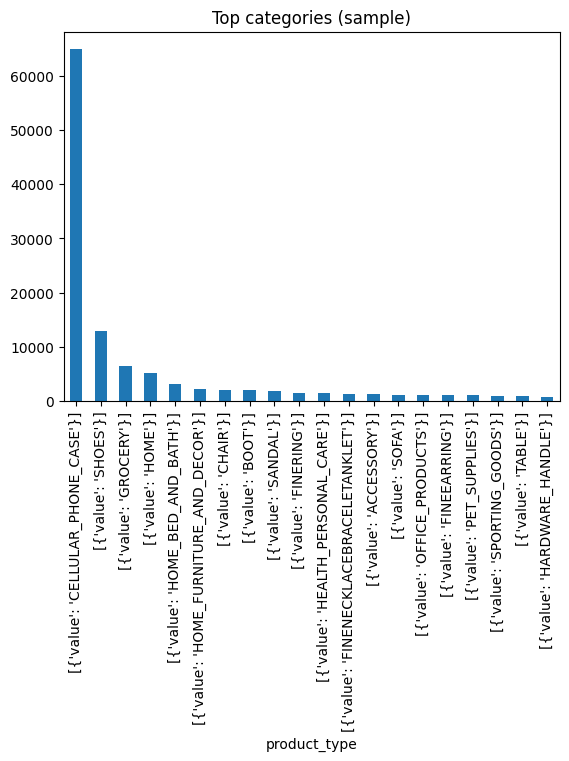

In [ ]:
ax = df['product_type'].astype(str).value_counts().head(20).plot(kind='bar', title='Top categories (sample)')
#df.columns

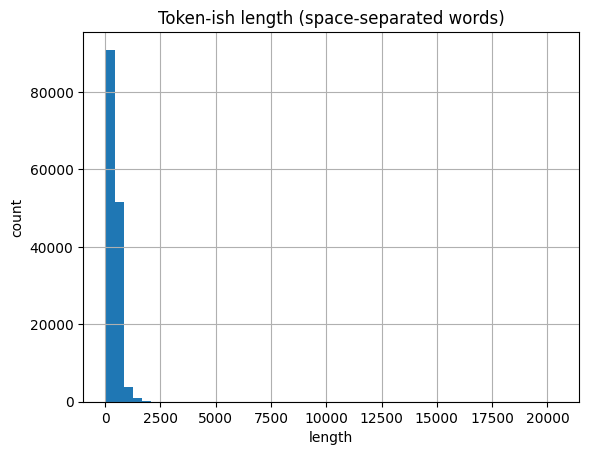

In [ ]:
import matplotlib.pyplot as plt

df['len_text'] = df['text_for_embed'].str.split().apply(len)

ax = df['len_text'].hist(bins=50)
ax.set_title('Token-ish length (space-separated words)')
ax.set_xlabel('length'); ax.set_ylabel('count')
plt.show()


## 4. Embedding models wrapper
A common interface to swap models (e5/bge/MiniLM).

In [ ]:
from sentence_transformers import SentenceTransformer
import torch, math

class Encoder:
    def __init__(self, model_name: str, device: str | None = None):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name, device=device)
    def encode(self, texts, batch_size=128, normalize=True):
        embs = self.model.encode(texts, batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=normalize)
        return embs

encoders = {alias: Encoder(m) for alias, m in ENCODERS.items()}
list(encoders.keys())

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

['e5-base', 'bge-base', 'MiniLM']

## 5. Create a small eval set (queries ↔ positives)
We synthesize simple queries from product rows (title + constraints). In real use, label true pairs or mine from click logs.

In [ ]:
# def make_query(row):
#     t = extract_value(row['item_name']).lower()
#     cat = extract_value(row['product_type']).lower()
#     # very naive query synthesis
#     return f"{cat} {t}".strip()

df_merged = df_merged.reset_index(drop=True)
df_merged['global_idx'] = np.arange(len(df_merged))
# sample = df_merged.sample(n=min(2000, len(df_merged)), random_state=SEED).reset_index(drop=True)
# sample['query'] = sample.apply(make_query, axis=1)
# sample[['item_name','product_type','query']].head(5)

# pos = sample['global_idx'].to_numpy()
def make_query(row):
    t = extract_value(row['item_name']).lower()
    cat = extract_value(row['product_type']).lower()
    return f"{cat} {t}".strip()

sample = df_merged.sample(n=min(2000, len(df_merged)), random_state=SEED).reset_index(drop=True)
sample['query'] = sample.apply(make_query, axis=1)
pos = sample['global_idx'].to_numpy()

## 6. Compute embeddings per model

In [ ]:

def prep_docs(texts, name):
    # e5/bge like "passage: "; MiniLM can work raw
    if 'e5' in name or 'bge' in name:
        return [f"passage: {t}" for t in texts]
    return texts

def prep_queries(texts, name):
    if 'e5' in name or 'bge' in name:
        return [f"query: {t}" for t in texts]
    return texts
def run_encode(enc, texts, normalize=True, batch_size=128):
    # SentenceTransformer models
    if hasattr(enc, "encode"):
        sig = enc.encode.__code__.co_varnames
        if "convert_to_numpy" in sig:
            return enc.encode(
                texts,
                convert_to_numpy=True,
                normalize_embeddings=normalize,
                batch_size=batch_size,
                show_progress_bar=True
            )
        else:
            # Plain .encode() (e.g. HuggingFace model directly)
            out = enc.encode(texts)
            return np.array(out)
    else:
        raise ValueError(f"Unknown encoder type: {type(enc)}")

docs_text = df_merged['text_for_embed_aug'].astype(str).tolist()
queries_text = sample['query'].astype(str).tolist()

EMB = {}
for name, enc in encoders.items():
    D_texts = prep_docs(docs_text, name)      # adds "passage: " for e5/bge
    Q_texts = prep_queries(queries_text, name)# adds "query: " for e5/bge
    print(f"Encoding with {name} ...")
    EMB[(name,'docs')] = run_encode(enc, D_texts)
    EMB[(name,'queries')] = run_encode(enc, Q_texts)

# EMB = {}
# for name, enc in encoders.items():
#     print(f"Encoding with {name} ...")
#     EMB[(name,'docs')] = enc.encode(texts)
#     EMB[(name,'queries')] = enc.encode(queries)
print({k[0] for k in EMB.keys()})

Encoding with e5-base ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with bge-base ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Encoding with MiniLM ...

Batches:   0%|          | 0/1269 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

{'MiniLM', 'bge-base', 'e5-base'}

## 7. Retrieval metrics (Recall@K, nDCG@K)
Each query's positive is the row-aligned product (index match). We'll also include **hard negatives** via nearest categories to stress the model.

In [ ]:
import numpy as np, faiss

def build_ip_index(doc_emb: np.ndarray) -> faiss.Index:
    # use cosine by normalizing first, then Inner Product (IP)
    doc = doc_emb.astype('float32')
    faiss.normalize_L2(doc)
    index = faiss.IndexFlatIP(doc.shape[1])
    index.add(doc)
    return index

def topk_search(index: faiss.Index, q_emb: np.ndarray, k: int = 10):
    q = q_emb.astype('float32')
    faiss.normalize_L2(q)
    # D: similarities, I: indices in FULL docs
    D, I = index.search(q, k)
    return D, I

def recall_at_k_from_indices(I: np.ndarray, pos: np.ndarray) -> float:
    # I: Q x K integer indices; pos: Q positives (doc indices)
    return float((I == pos[:, None]).any(axis=1).mean())

def ndcg_at_k_from_indices(I: np.ndarray, pos: np.ndarray) -> float:
    # binary relevance; DCG=1/log2(rank+1) if found; else 0
    match = (I == pos[:, None])
    found = match.any(axis=1)
    # rank position (0-based) where the positive appears
    rank = np.where(found, match.argmax(axis=1), -1)
    dcg = np.where(found, 1.0 / np.log2(rank + 2.0), 0.0)
    return float(dcg.mean())

# ---- usage ----
k = 10
metrics = []
for name in ENCODERS.keys():
    d = EMB[(name, 'docs')]      # full docs (D x d)
    q = EMB[(name, 'queries')]   # sampled queries (Q x d)
    index = build_ip_index(d)
    _, I = topk_search(index, q, k=k)
    r = recall_at_k_from_indices(I, pos)
    n = ndcg_at_k_from_indices(I, pos)
    metrics.append({"model": name, f"Recall@{k}": r, f"nDCG@{k}": n})
pd.DataFrame(metrics)


/tmp/ipython-input-3726928851.py:28: RuntimeWarning: divide by zero encountered in divide
  dcg = np.where(found, 1.0 / np.log2(rank + 2.0), 0.0)


,model,Recall@10,nDCG@10
0,e5-base,0.721,0.556409
1,bge-base,0.441,0.295672
2,MiniLM,0.500,0.354922


## 8. Inter-/Intra-category cosine analysis
Measure how well embeddings separate categories by comparing normalized intra vs inter-category similarities.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

SEED = 42
rng = np.random.default_rng(SEED)

# 1) Make labels for the FULL df (not the sample), using  JSON flattener
# def extract_value(obj):
#     if obj is None: return ''
#     if isinstance(obj, str): return obj.strip()
#     if isinstance(obj, (int,float,bool)): return str(obj)
#     if isinstance(obj, dict):
#         return extract_value(obj.get('value','')) or ' '.join(extract_value(v) for v in obj.values())
#     if isinstance(obj, list):
#         return ' '.join(extract_value(x) for x in obj)
#     return ''

df['cat_label'] = df['product_type'].apply(extract_value).str.strip().replace('', 'other')

# 2) Choose a manageable subset of docs (e.g., 3–5k)
N = min(2000, len(df))
subset_idx = rng.choice(len(df), size=N, replace=False)
labels_sub = df['cat_label'].to_numpy()[subset_idx]

# 3) Get the same subset of embeddings per model
def inter_intra_scores(emb_sub, labels_sub):
    # emb_sub: (N, d) L2-normalized (if not, normalize first)
    sim = cosine_similarity(emb_sub)  # N x N (OK for N ~ 5k)
    intra, inter = [], []
    for i in range(len(emb_sub)):
        same = (labels_sub == labels_sub[i])
        diff = ~same
        # exclude self when computing intra mean
        if same.sum() > 1:
            m_intra = sim[i, same].sum() - 1.0  # remove self-sim=1
            m_intra /= (same.sum() - 1)
        else:
            m_intra = np.nan  # no other item in that class
        m_inter = sim[i, diff].mean() if diff.any() else np.nan
        intra.append(m_intra); inter.append(m_inter)
    # drop NaNs safely
    intra = np.array([x for x in intra if not np.isnan(x)])
    inter = np.array([x for x in inter if not np.isnan(x)])
    return float(intra.mean()), float(inter.mean())

rows = []
for name in ENCODERS.keys():
    emb_full = EMB[(name,'docs')]                 # (149k, d)
    emb_sub = emb_full[subset_idx]                # (N, d)
    intra, inter = inter_intra_scores(emb_sub, labels_sub)
    rows.append({"model": name, "intra_cos": intra, "inter_cos": inter, "delta": intra - inter})

pd.DataFrame(rows).sort_values('delta', ascending=False)

,model,intra_cos,inter_cos,delta
1,bge-base,0.856088,0.856361,-0.000274
0,e5-base,0.819984,0.820379,-0.000395
2,MiniLM,0.304189,0.304980,-0.000791


## 9. UMAP visualization
Project embeddings to 2D to visually inspect clustering by category.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


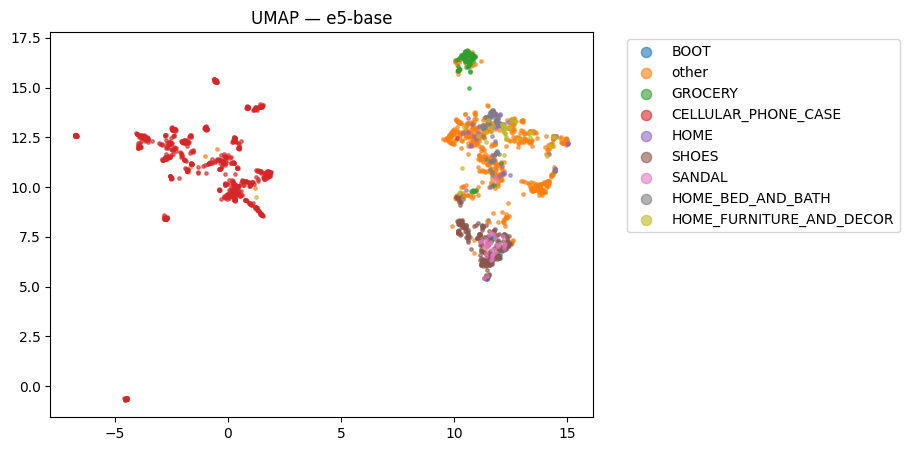

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


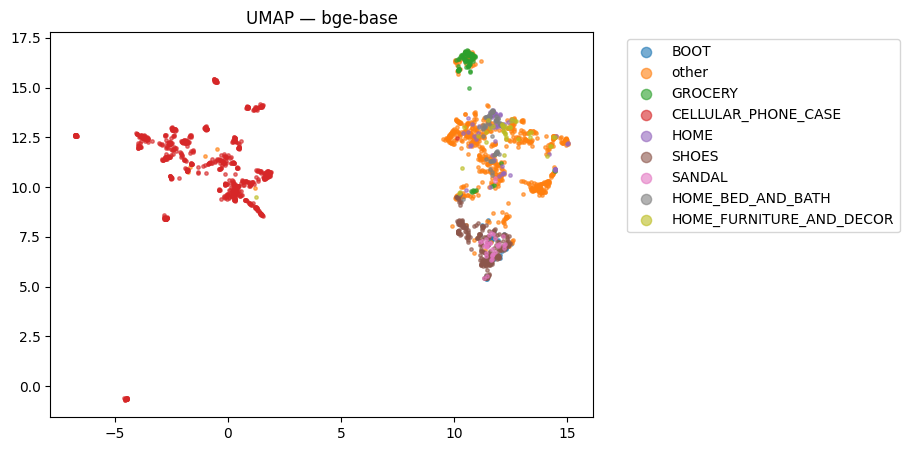

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


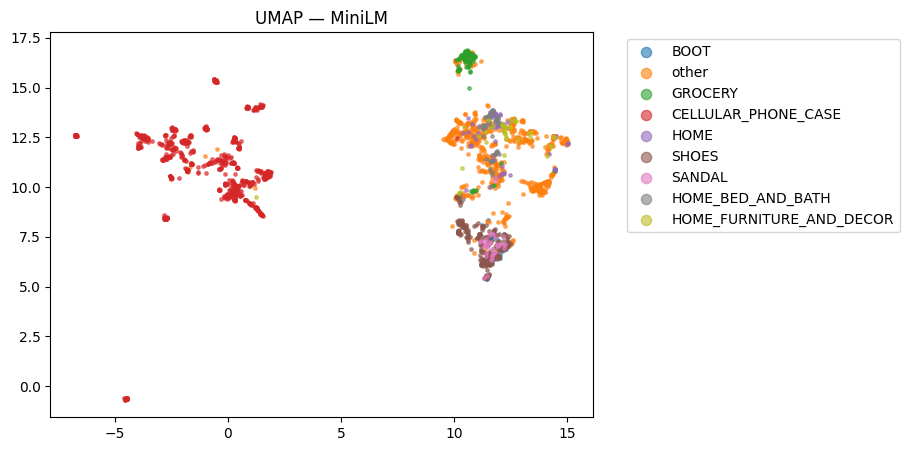

In [ ]:
import umap
import matplotlib.pyplot as plt

def extract_value(obj):
    if obj is None: return ''
    if isinstance(obj, str): return obj.strip()
    if isinstance(obj, (int, float, bool)): return str(obj)
    if isinstance(obj, dict):
        return extract_value(obj.get('value', '')) or ' '.join(extract_value(v) for v in obj.values())
    if isinstance(obj, list):
        return ' '.join(extract_value(el) for el in obj)
    return ''

sample_idx = sample['global_idx'].to_numpy()
emb = EMB[(name,'docs')]
emb_sub = emb[sample_idx]

# If your sample has product_type JSON, normalize it
if 'product_type' in sample.columns:
    sample['_label'] = sample['product_type'].apply(extract_value).str.strip()

def umap_plot(emb_sub, labels, title):
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=SEED)
    Z = reducer.fit_transform(emb_sub)
    # Map top few categories to colors
    cats = pd.Series(labels).fillna('')
    top = cats.value_counts().head(8).index
    col = cats.apply(lambda x: x if x in top else 'other')
    fig, ax = plt.subplots(figsize=(7,5))
    for c in col.unique():
        idx = (col == c).values
        ax.scatter(Z[idx,0], Z[idx,1], s=6, alpha=0.6, label=c)
    ax.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(title)
    plt.show()

for name in ENCODERS.keys():
    umap_plot(emb_sub, sample['_label'].tolist(), title=f'UMAP — {name}')

## 10. Save artifacts
Persist embeddings and a compact product table for later ANN indexing.

In [ ]:
# 2OUT = DATA_DIR / 'embeddings'
# OUT.mkdir(exist_ok=True)
# meta = sample[['item_name','product_type','text_for_embed']].copy()
# meta.to_parquet(OUT / 'sample_meta.parquet')
# for name in ENCODERS.keys():
#     np.save(OUT / f'{name}_docs.npy', EMB[(name,'docs')])
#     np.save(OUT / f'{name}_queries.npy', EMB[(name,'queries')])
# print('Saved to', OUT)

In [ ]:
# non_text_cols = [c for c in df_merged.columns if c not in text_cols]

# export_cols = ['item_id', 'item_name', 'product_type', 'text_for_embed_aug', 'image_url']
# meta = df_merged[export_cols].copy()

# # Attach embeddings
# BEST = "e5-base"   # or whichever model you want
# doc_emb = EMB[(BEST, 'docs')]
# assert len(doc_emb) == len(meta), "Embedding count must match rows"

# meta["embedding"] = [vec.tolist() for vec in doc_emb]

# # Save to Parquet
# OUT = Path("./data_abo/embeddings")
# OUT.mkdir(parents=True, exist_ok=True)

# out_path = OUT / f"products_{BEST}.parquet"
# meta.to_parquet(out_path, index=False)
# print("Wrote:", out_path, "with shape", meta.shape)

# Save embeddings to Google Drive

In [ ]:
from google.colab import drive
from pathlib import Path
import shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Pick your best encoder
BEST = "e5-base"

# 3. Build metadata DataFrame with embeddings
non_text_cols = [c for c in df_merged.columns if c not in text_cols]
export_cols = ['item_id', 'item_name', 'product_type', 'text_for_embed_aug', 'image_url']
meta = df_merged[export_cols].copy()
meta['item_name'] = meta['item_name'].apply(extract_value).str.strip()
meta['product_type'] = meta['product_type'].apply(extract_value).str.strip()

doc_emb = EMB[(BEST, 'docs')]
assert len(doc_emb) == len(meta), "Embedding count must match rows"
meta["embedding"] = [vec.tolist() for vec in doc_emb]

# 4. Save to Parquet in Colab tmp
OUT = Path("/content/tmp_embeds")
OUT.mkdir(parents=True, exist_ok=True)
parquet_path = OUT / f"products_{BEST}.parquet"
meta.to_parquet(parquet_path, index=False)
print("Saved parquet:", parquet_path, "with shape", meta.shape)

# 5. Zip it
zip_path = Path(f"/content/products_{BEST}.zip")
shutil.make_archive(str(zip_path.with_suffix("")), 'zip', root_dir=OUT, base_dir=parquet_path.name)

print("Created zip:", zip_path)

# 6. Move zip into Google Drive (change folder name if you like)
drive_folder = Path("/content/drive/MyDrive/abo_project")
drive_folder.mkdir(parents=True, exist_ok=True)
shutil.move(str(zip_path), str(drive_folder / zip_path.name))

print("Moved to Drive:", drive_folder / zip_path.name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saved parquet: /content/tmp_embeds/products_e5-base.parquet with shape
(162416, 6)

Created zip: /content/products_e5-base.zip

Moved to Drive: /content/drive/MyDrive/abo_project/products_e5-base.zip

## 11. Next steps
- Replace synthetic queries with a labeled eval set (query → relevant product IDs).
- Try **hybrid search**: BM25 vs vector, score fusion.
- Add a **cross-encoder reranker** on top-K and re-measure metrics.
- Add **image captions** and compare text-only vs text+captions.
- (Optional) Try quantized encoders for speed; log latency per model.